In [1]:
from d2l import mxnet as d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

In [2]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
       nn.AvgPool2D(pool_size=2, strides=2),
       nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
       nn.AvgPool2D(pool_size=2, strides=2),
       nn.Dense(120, activation="sigmoid"),
       nn.Dense(84, activation="sigmoid"),
       nn.Dense(10))

In [3]:
X = np.random.uniform(size=(1, 1, 28, 28))
net.initialize()

for layer in net:
    X = layer(X)
    print(layer.name, "output shape:\t", X.shape)

conv0 output shape:	 (1, 6, 28, 28)
pool0 output shape:	 (1, 6, 14, 14)
conv1 output shape:	 (1, 16, 10, 10)
pool1 output shape:	 (1, 16, 5, 5)
dense0 output shape:	 (1, 120)
dense1 output shape:	 (1, 84)
dense2 output shape:	 (1, 10)


In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [18]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if not device:
        device = list(net.collect_params().values())[0].list_ctx()[0]
    
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X, y = X.as_in_ctx(device), y.as_in_ctx(device)
        metric.add(d2l.accuracy(net(X), y), y.size)
        
    return metric[0] / metric[1]

In [19]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    net.initialize(force_reinit=True, ctx=device, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            # Here is the major difference from `d2l.train_epoch_ch3`
            X, y = X.as_in_ctx(device), y.as_in_ctx(device)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
    f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
    f'on {str(device)}')

loss 0.470, train acc 0.824, test acc 0.815
49963.4 examples/sec on gpu(0)


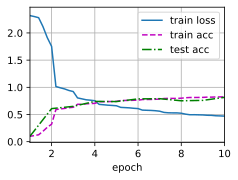

In [22]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [39]:
# ReLU
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='relu'),
       nn.AvgPool2D(pool_size=2, strides=2),
       nn.Conv2D(channels=16, kernel_size=5, activation='relu'),
       nn.AvgPool2D(pool_size=2, strides=2),
       nn.Dense(120, activation="sigmoid"),
       nn.Dense(84, activation="sigmoid"),
       nn.Dense(10))

loss 0.306, train acc 0.886, test acc 0.864
53261.8 examples/sec on gpu(0)


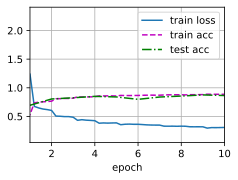

In [40]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [ ]:
# Layer 1 kernel_size=3, padding 1 --> loss 0.483, train acc 0.819, test acc 0.809
# Sigmoid to ReLU --> loss 0.306, train acc 0.886, test acc 0.864

In [41]:
# ReLU
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
       nn.MaxPool2D(pool_size=2, strides=2),
       nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
       nn.MaxPool2D(pool_size=2, strides=2),
       nn.Dense(120, activation="sigmoid"),
       nn.Dense(84, activation="sigmoid"),
       nn.Dense(10))

loss 0.405, train acc 0.851, test acc 0.805
51883.8 examples/sec on gpu(0)


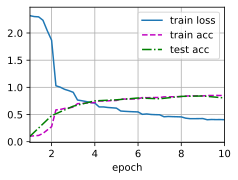

In [42]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [48]:
for x_batch, y_batch in train_iter:
    break

256


In [56]:
device = list(net.collect_params().values())[0].list_ctx()[0]
net[2](net[1](net[0](x_batch.as_in_ctx(device))))

array([[[[9.96204317e-01, 9.94408250e-01, 3.48222196e-01, ...,
          9.21025313e-03, 1.39691215e-02, 6.46990776e-01],
         [9.97259140e-01, 9.84049320e-01, 7.51642361e-02, ...,
          3.66433663e-03, 1.89349509e-03, 3.19505006e-01],
         [9.97467518e-01, 9.69603837e-01, 4.96257581e-02, ...,
          5.18552214e-03, 1.16060488e-03, 1.58870235e-01],
         ...,
         [9.85977054e-01, 9.14766073e-01, 1.33036152e-01, ...,
          1.70146804e-02, 2.78606964e-03, 1.34300226e-02],
         [9.72400129e-01, 9.44188714e-01, 3.13115001e-01, ...,
          6.14295807e-03, 2.92723277e-03, 2.39873696e-02],
         [9.34331536e-01, 9.63087559e-01, 5.22070169e-01, ...,
          2.09957128e-03, 3.62160266e-03, 4.88534048e-02]],

        [[8.71452272e-01, 2.06641331e-02, 6.12946518e-04, ...,
          1.48249030e-01, 9.73522186e-01, 9.98399556e-01],
         [6.69302166e-01, 4.84905532e-03, 2.51683028e-04, ...,
          5.84385693e-02, 9.44939315e-01, 9.99046743e-01],
        

TypeError: copyto does not support type <class 'str'>